In [1]:
from rdkit import Chem
from rdkit.Chem import rdMolTransforms
from rdkit.Chem import rdmolfiles

import os,sys,subprocess
from tqdm import tqdm
import numpy as np
from pymol import cmd
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import pickle
from itertools import groupby
import warnings
warnings.filterwarnings('ignore')
import pymol
from pymol import cmd
from glob import glob

from process_pdb import process_pdb
from process_ligand import prelig4swiss, batch_rotatable_bonds
from pymol_center_of_mass import get_com
from cif2gro import cif2gro
from match_mol2_coordinates_from_gro import get_mol2_coord
from extended_functions import *

In [2]:
pocket_map = {'CDK2': '6-21+29-36+61-68+76-92+125-150',
              'FXA': '41-46+76-90+159-168+171-186+205-216',
              'HSP90': '93-100+101-121+131-144+145-153'}
pro_map = {'CDK2':'1fin', 'FXA': '1ezq', 'HSP90': '1uyg'}

## CDK2 cases with initially large RMSD 

### Analyses and prepare cases

In [3]:
# Taken CDK2 as an example. We first find the cases 
# whose initial docking structures have large RMSD
dt = pd.read_csv("data/CDK2_RMSD_features.tsv", 
                 sep = '\t', index_col = 0)
dt = dt.transpose()
l_bad = dt[dt['complex_0']> 10].index.tolist()
print(l_bad)

['1h24_TPO_LIG', '1h25_TPO_LIG', '1h26_TPO_LIG', '1h27_TPO_LIG', '1h28_TPO_LIG', '1ke9_LS5_LIG', '1w98_TPO_LIG', '2jgz_TPO_LIG', '2wma_TPO_LIG', '2wmb_TPO_LIG', '3ezr_EZR_LIG', '3pxf_2AN_LIG', '3pxz_2AN_LIG', '3py1_2AN_LIG', '3r9h_Z67_LIG', '3rni_21Z_LIG', '4fku_60K_LIG', '6q3b_PYZ_LIG', '6q3c_BYZ_LIG', '6q3f_HEW_LIG']


In [4]:
# visualize and choose several case for further 3t experiments
# 1ke9_LS5_LIG: 10.22995
# 3r9h_Z67_LIG: 9.9453
# 3rni_21Z_LIG: 10.47056

# files are prepared for 3t
# which are in CDK2_case/initial_pose/ folder

### Postprocess 3T generated complex

In [5]:
# Two runs of 3t experiments are carried out.
# In the first round we used larger energitic kicks
# and extended the 3t minimization to 5000 steps.
# Then we visualized the generated structures and chose
# several promising structures for an extra 5000 step minimization.
# Here we show the round two results

for j in ['CDK2_case/3t_pose/cocry_1ke9_LS5_LIG_dock_1FIN_1/',
          'CDK2_case/3t_pose/cocry_3r9h_Z67_LIG_dock_1FIN_1/',
          'CDK2_case/3t_pose/cocry_3rni_21Z_LIG_dock_1FIN_1/']:
    l = sorted([x for x in glob(f'{j}step3*.cif')])
    for i in l:
        ref = f'{j}/complex.gro'
        out = i.replace('.cif', '.gro')
        cif2gro(ref, i, out)

### Calculate the RMSD to cocrystal structures

In [6]:
out = []
# alignment
l = [x for x in glob('CDK2_case/3t_pose/*/step_*.gro')]
for i in l:
    ref = f'CDK2_case/initial_pose/{i.split("/")[-2].split("_")[1]}_ENS_dH.pdb'
    po = pocket_map['CDK2']
    align_gro(i, ref, po)
        
# calculate RMSD
l = [x for x in glob('CDK2_case/3t_pose/*/step_*.mol2')]
for i in l:
    ref_lig = [x for x in glob('CDK2_case/initial_pose/*_LIG.pdb')
               if i.split("/")[-2].split("_")[1] in x][0]
    ob = subprocess.Popen(['python', '-m', 'spyrmsd', ref_lig, i],
                          stdin=subprocess.PIPE, 
                          stdout=subprocess.PIPE,
                          stderr=subprocess.PIPE)
    a = ob.stdout.read()
    try:
        a = float(a.strip())
    except:
        a = None
    na = i.split("/")[-2].split("_")[1]+'_'+i.split("/")[-1].split(".")[-3].split('_')[-1]
    out.append([na, a])
    
for i in [x for x in glob('CDK2_case/initial_pose/cocry_*.mol2')]:
    ref_lig = [x for x in glob('CDK2_case/initial_pose/*_LIG.pdb') 
               if i.split("/")[-1].split("_")[1] in x][0]
    ob = subprocess.Popen(['python', '-m', 'spyrmsd', ref_lig, i],
                          stdin=subprocess.PIPE, 
                          stdout=subprocess.PIPE,
                          stderr=subprocess.PIPE)
    a = ob.stdout.read()
    try:
        a = float(a.strip())
    except:
        a = None
    na = i.split("/")[-1].split("_")[1]
    out.append([na, a])

In [7]:
sorted(out)

[['1ke9', 10.22995], ['3r9h', 9.9453], ['3rni', 10.47056]]

## ADRB2 alternative binding mode identification

### Prepare cases

In [8]:
# prepare protein
process_pdb('ADRB2_case/data/3nya.pdb', '3nya', 'ADRB2_case/processed/')
l_lig = ['ADRB2_case/data/3ny9_LIG.pdb']
for i in l_lig:
    cmd.load(i, i)
    com = get_com('all')
    f = open('ADRB2_case/processed/center.txt','w')
    f.write(f'X,{com[0]}\nY,{com[1]}\nZ,{com[2]}')
    f.close()
    cmd.delete('all')

In [9]:
%%bash
obabel -ipdb ADRB2_case/data/3nya_JTZ.pdb -O ADRB2_case/data/3nya_JTZ.smi
obabel -ismi ADRB2_case/data/3nya_JTZ.smi -O ADRB2_case/data/3nya_JTZ.sdf --gen3D
smina -r ADRB2_case/processed/3nya.pdb -l ADRB2_case/data/3nya_JTZ.sdf -o ADRB2_case/processed/3nya_JTZ_dock.sdf --autobox_ligand=ADRB2_case/data/3ny9_LIG.pdb --scoring=vinardo --factor=100 --num_modes=3 --exhaustiveness=16
obabel -isdf ADRB2_case/processed/3nya_JTZ_dock.sdf -l 3 -O ADRB2_case/processed/3nya_JTZ_dock_.sdf -m

Process is interrupted.


In [10]:
prelig4swiss('ADRB2_case/processed/3nya_JTZ_dock_1.sdf',
            'ADRB2_case/processed/3nya_JTZ_dock_1.mol2')
prelig4swiss('ADRB2_case/processed/3nya_JTZ_dock_2.sdf',
            'ADRB2_case/processed/3nya_JTZ_dock_2.mol2')
prelig4swiss('ADRB2_case/processed/3nya_JTZ_dock_3.sdf',
            'ADRB2_case/processed/3nya_JTZ_dock_3.mol2')
batch_rotatable_bonds('ADRB2_case/processed/')

### Postprocess 3T generated complex

In [11]:
# Two runs of 3t experiments are carried out.
# In the first round we used larger energitic kicks
# and extended the 3t minimization to 5000 steps.
# Then we visualized the generated structures and chose
# several promising structures for an extra 5000 step minimization.
# Here we show the round two results

for j in [1,2,3]:
    l = sorted([x for x in glob(f'ADRB2_case/3t_pose/3nya_JTZ_dock_{j}/step*.cif')])
    for i in l:
        ref = 'ADRB2_case/3t_pose/complex.gro'
        out = i.replace('.cif', '.gro')
        cif2gro(ref, i, out)

## Regenerate ligand conformations from SMILES

### Co-crystal ligand structure regeration

In [14]:
## convert the cocrystal ligand pdb to SMILES
for pdb in ["CDK2", "HSP90", "FXA"]:
    subprocess.run(['mkdir',f'data/{pdb}/cocry_regenerated/'])
    l = [x for x in glob(f'data/{pdb}/cocry_dataset/*.pdb')]
    f = open(f'{pdb}_smi_gen.txt','w')
    for i in l:
        f.write(f'obabel -ipdb {i} -O {i.replace("pdb","smi").replace("cocry_dataset", "cocry_regenerated")}\n')
    f.close()
# bash CDK2_smi_gen.txt
# bash HSP90_smi_gen.txt
# bash FXA_smi_gen.txt

In [15]:
## generate 3D strcture from the SMILES
for pdb in ["CDK2", "HSP90", "FXA"]:
    l = [x for x in glob(f'data/{pdb}/cocry_regenerated/*.smi')]
    f = open(f'{pdb}_sdf_gen.txt','w')
    for i in l:
        f.write(f'obabel -ismi {i} -O {i.replace(".smi",".sdf")} --gen3D\n')
    f.close()
# bash CDK2_sdf_gen.txt
# bash HSP90_sdf_gen.txt
# bash FXA_sdf_gen.txt


In [16]:
## docking to respect proteins
ref_pdb = {'CDK2':'1fin_ENS.pdb',
           'HSP90':'1uyg_ENS.pdb',
           'FXA':'1ezq_ENS.pdb'}
ref_lig = {'CDK2':'1fin_ATP_LIG.pdb',
           'HSP90':'1uyg_PU2_LIG.pdb',
           'FXA':'1ezq_RPR_LIG.pdb'}
for pdb in ["CDK2", "HSP90", "FXA"]:
    subprocess.run(['mkdir',f'data/{pdb}/cocry_docked/'])
    ligs = sorted([x for x in glob(f'data/{pdb}/cocry_regenerated/*.sdf')])
    dock_txt = open(f'{pdb}_docking.txt','w')
    for i in ligs:
        s = f"smina -r data/{pdb}/{ref_pdb[pdb]} -l {i} \
            -o {i.replace('cocry_regenerated', 'cocry_docked')}\
            --autobox_ligand=data/{pdb}/{ref_lig[pdb]} \
            --scoring=vinardo --factor=100 --num_modes=3\
            --exhaustiveness=16\n"
        dock_txt.write(s)
    dock_txt.close()
# bash CDK2_docking.txt
# bash HSP90_docking.txt
# bash FXA_docking.txt

In [17]:
## split the docked files to keep the first three conformations
for pdb in ['CDK2', 'FXA', 'HSP90']:
    l = sorted([x for x in glob(f'data/{pdb}/cocry_docked/*.sdf')])
    f = open(f'{pdb}_spliting.txt','w')
    for i in l:
        j = i.replace('.sdf', f'_.sdf')
        s = f'obabel -isdf {i} -l 3 -O {j} -m\n'
        f.write(s)
    f.close()
# bash CDK2_spliting.txt
# bash HSP90_spliting.txt
# bash FXA_spliting.txt


In [18]:
## prepare the parameters for 3T
for pdb in ['CDK2', 'FXA', 'HSP90']:
    subprocess.run(['mkdir',f'data/{pdb}/cocry_processed/'])
    l = sorted([x for x in glob(f'data/{pdb}/cocry_docked/*.sdf')])
    for lig in l:
        out = lig.replace('cocry_docked', 'cocry_processed').replace('.sdf','.mol2')
        try:
            prelig4swiss(lig, out)
        except:
            pass

In [19]:
%%bash
rm CDK2_*.txt HSP90_*.txt FXA_*.txt

### Align the docked conformations to cocrystal structures

In [20]:
## some references
pocket_map = {'CDK2': '6-21+29-36+61-68+76-92+125-150',
              'FXA': '41-46+76-90+159-168+171-186+205-216',
              'HSP90': '93-100+101-121+131-144+145-153'}
pro_map = {'CDK2':'1fin', 'FXA': '1ezq', 'HSP90': '1uyg'}

# align the original docked ligand poses to the cocrystal poses
for pro in ['CDK2', 'FXA', 'HSP90']:
    l = sorted([x for x in glob(f'data/{pro}/cocry_processed_ori/*.mol2')])
    for i in l:
        pdb = f'data/{pro}/{pro_map[pro]}_ENS.pdb'
        p = i.split('/')[-1].split('_')[1]
        ref = f'data/{pro}/pdb_prepared/{p}_ENS_dH.pdb'
        po = pocket_map[pro]
        align(i, pdb, ref, po)
        
        
# align the SMILES docked ligand poses to the cocrystal poses
for pro in ['CDK2', 'FXA', 'HSP90']:
    l = sorted([x for x in glob(f'data/{pro}/cocry_processed/*.mol2')])
    for i in l:
        pdb = f'data/{pro}/{pro_map[pro]}_ENS.pdb'
        p = i.split('/')[-1].split('_')[0]
        ref = f'data/{pro}/pdb_prepared/{p}_ENS_dH.pdb'
        po = pocket_map[pro]
        align(i, pdb, ref, po)

### Calculate the RMSD to cocrystal structures

In [21]:
# calculate the RMSD of original docked ligand poses to the cocrystal poses
out = {'CDK2':[], 'FXA':[], 'HSP90':[]}

for pdb in ['CDK2', 'FXA', 'HSP90']:
    for j in [1,2,3]:
        l = sorted([x for x in glob(f'data/{pdb}/cocry_processed_ori/*_{j}_0.mol2')])
        pbar = tqdm(total = len(l), leave = True, position = 0)
        pbar.set_description(f'{pdb}_{j}')
        for i in l:
            ref_lig = f'data/{pdb}/cocry_dataset/'+'_'.join(i.split('_')[3:6])+'.pdb'
            pbar.update(1)
            ob = subprocess.Popen(['python', '-m', 'spyrmsd', i, ref_lig],
                                  stdin=subprocess.PIPE, stdout=subprocess.PIPE,stderr=subprocess.PIPE)
            a = ob.stdout.read()
            try:
                a = float(a.strip())
                out[f'{pdb}'].append(a)
            except:
                a = None
                
# calculate the RMSD of SMILES docked ligand poses to the cocrystal poses
out_2 = {'CDK2':[], 'FXA':[], 'HSP90':[]}
for pdb in ['CDK2', 'FXA', 'HSP90']:
    for j in [1,2,3]:
        l = sorted([x for x in glob(f'data/{pdb}/cocry_processed/*_{j}_0.mol2')])
        pbar = tqdm(total = len(l), leave = True, position = 0)
        pbar.set_description(f'{pdb}_{j}')
        for i in l:
            ref_lig = f'data/{pdb}/cocry_dataset/'+i.split('/')[-1].replace(f'_{j}_0.mol2','.pdb')
            pbar.update(1)
            ob = subprocess.Popen(['python', '-m', 'spyrmsd', i, ref_lig],
                                  stdin=subprocess.PIPE, stdout=subprocess.PIPE,stderr=subprocess.PIPE)
            a = ob.stdout.read()
            try:
                a = float(a.strip())
                out_2[f'{pdb}'].append(a)
            except:
                a = None
                

HSP90_3: 100%|██████████| 9/9 [00:03<00:00,  2.11it/s]]

In [24]:
## Get the RMSD of 3T conformations from previous data
dt_cdk2 = pd.read_csv('data/CDK2_RMSD_features.tsv', index_col = 0, sep = '\t')
dt_hsp90 = pd.read_csv('data/HSP90_RMSD_features.tsv', index_col = 0, sep = '\t')
dt_fxa = pd.read_csv('data/FXA_RMSD_features.tsv', index_col = 0, sep = '\t')
dt_cdk2 = dt_cdk2.transpose()
dt_hsp90 = dt_hsp90.transpose()
dt_fxa = dt_fxa.transpose()

idx_0 = []
idx = [x for x in dt_cdk2.columns.tolist() if 'complex' not in x]
for i,r in dt_cdk2.iterrows():
    l1 = sorted([(x, r[x]) for x in idx if x.endswith('_0')],key = lambda x:x[1])[0]
    l2 = sorted([(x, r[x]) for x in idx if x.endswith('_1')],key = lambda x:x[1])[0]
    l3 = sorted([(x, r[x]) for x in idx if x.endswith('_2')],key = lambda x:x[1])[0]
    idx_0.append([i, l1,l2,l3])
    
idx_1 = []
idx = [x for x in dt_hsp90.columns.tolist() if 'complex' not in x]
for i,r in dt_hsp90.iterrows():
    l1 = sorted([(x, r[x]) for x in idx if x.endswith('_0')],key = lambda x:x[1])[0]
    l2 = sorted([(x, r[x]) for x in idx if x.endswith('_1')],key = lambda x:x[1])[0]
    l3 = sorted([(x, r[x]) for x in idx if x.endswith('_2')],key = lambda x:x[1])[0]
    idx_1.append([i, l1,l2,l3])
    
idx_2 = []
idx = [x for x in dt_fxa.columns.tolist() if 'complex' not in x]
for i,r in dt_fxa.iterrows():
    l1 = sorted([(x, r[x]) for x in idx if x.endswith('_0')],key = lambda x:x[1])[0]
    l2 = sorted([(x, r[x]) for x in idx if x.endswith('_1')],key = lambda x:x[1])[0]
    l3 = sorted([(x, r[x]) for x in idx if x.endswith('_2')],key = lambda x:x[1])[0]
    idx_2.append([i, l1,l2,l3])
    
out_3t = {'CDK2':[], 'FXA':[], 'HSP90':[]}
out_3t['CDK2'] = [x[1][1] for x in idx_0]+[x[2][1] for x in idx_0]+[x[3][1] for x in idx_0]
out_3t['HSP90'] = [x[1][1] for x in idx_1]+[x[2][1] for x in idx_1]+[x[3][1] for x in idx_1]
out_3t['FXA'] = [x[1][1] for x in idx_2]+[x[2][1] for x in idx_2]+[x[3][1] for x in idx_2]


### Calculate bond length and dihydral

In [25]:
## convert the cocrystal ligand pdb to mol2 files
for pdb in ['CDK2', 'FXA', 'HSP90']:
    l = sorted([x for x in glob(f'data/{pdb}/cocry_dataset/*.pdb')])
    for i in l:
        cmd.load(i,'lig')
        cmd.save(i.replace('.pdb','.mol2'), 'lig')
        cmd.delete('lig')

# get bond distribution cocrystal MOLs
out_bl_0 = {'CDK2':[], 'FXA':[], 'HSP90':[]}
out_di_0 = {'CDK2':[], 'FXA':[], 'HSP90':[]}
for pdb in ['CDK2', 'FXA', 'HSP90']:
    l = sorted([x for x in glob(f'{pdb}/cocry_dataset/*.mol2')])
    for i in l:
        try:
            mol = Chem.MolFromMol2File(i)
            bl = get_bond_length(mol)
            out_bl_0[f'{pdb}']+= bl
            di = get_dihedral_angle(mol)
            out_di_0[f'{pdb}']+= di
        except:
            pass
        

In [26]:
## get bond distribution original smina docked MOLs
out_bl = {'CDK2':[], 'FXA':[], 'HSP90':[]}
out_di = {'CDK2':[], 'FXA':[], 'HSP90':[]}
for pdb in ['CDK2', 'FXA', 'HSP90']:
    for j in [1,2,3]:
        l = sorted([x for x in glob(f'data/{pdb}/cocry_processed_ori/*_{j}.mol2')])
        for i in l:
            try:
                mol = Chem.MolFromMol2File(i)
                bl = get_bond_length(mol)
                out_bl[f'{pdb}']+= bl
                di = get_dihedral_angle(mol)
                out_di[f'{pdb}']+= di
            except:
                pass


RDKit WARNING: [21:19:25] cocrystal/docking_cocrystal/1b38_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:25] cocrystal/docking_cocrystal/1b39_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:25] cocrystal/docking_cocrystal/1fin_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:25] cocrystal/docking_cocrystal/1b38_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:25] cocrystal/docking_cocrystal/1b39_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:25] cocrystal/docking_cocrystal/1fin_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:25] cocrystal/docking_cocrystal/1b38_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:25] cocrystal/docking_cocrystal/1b39_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:25] cocrystal/docking_cocr

In [27]:
# get bond distribution original smina docked MOLs
out_bl_2 = {'CDK2':[], 'FXA':[], 'HSP90':[]}
out_di_2 = {'CDK2':[], 'FXA':[], 'HSP90':[]}
for pdb in ['CDK2', 'FXA', 'HSP90']:
    for j in [1,2,3]:
        l = sorted([x for x in glob(f'data/{pdb}/cocry_processed/*_{j}.mol2')])
        for i in l:
            try:
                mol = Chem.MolFromMol2File(i)
                bl = get_bond_length(mol)
                out_bl_2[f'{pdb}']+= bl
                di = get_dihedral_angle(mol)
                out_di_2[f'{pdb}']+= di
            except:
                pass

RDKit WARNING: [21:19:28] data/CDK2/cocry_dataset/1b38_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:28] data/CDK2/cocry_dataset/1b39_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:28] data/CDK2/cocry_dataset/1fin_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:28] data/CDK2/cocry_dataset/1b38_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:28] data/CDK2/cocry_dataset/1b39_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:28] data/CDK2/cocry_dataset/1fin_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:28] data/CDK2/cocry_dataset/1b38_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:28] data/CDK2/cocry_dataset/1b39_ATP_LIG.pdb: warning - O.co2 with non C.2 or S.o2 neighbor.
RDKit WARNING: [21:19:28] data/CDK2/cocry_dataset/1fin_ATP_LIG.pdb: warning - O.

In [32]:
## get bond distribution 3T MOLs
## example code for calculating the geo features
#out_bl_3t = {'CDK2':[], 'FXA':[], 'HSP90':[]}
#out_di_3t = {'CDK2':[], 'FXA':[], 'HSP90':[]}
#
#l1 = [x for x in glob('path_to_3t_folder/*.mol2')]
#for i in l1:
#    try:
#        mol = Chem.MolFromMol2File(i)
#        bl = get_bond_length(mol)
#        out_bl_3t['CDK2']+= bl
#        di = get_dihedral_angle(mol)
#        out_di_3t['CDK2']+= di
#    except:
#        pass

### Get the figures

In [33]:
## load data
out = pickle.load(open('data/docked_ori_rmsd.pkl','rb'))
out_2 = pickle.load(open('data/docked_SMILES_rmsd.pkl','rb'))
out_3t = pickle.load(open('data/3t_rmsd.pkl','rb'))

out_bl_0,out_di_0 = pickle.load(open('data/cocry_geo.pkl','rb'))
out_bl,out_di = pickle.load(open('data/docked_ori_geo.pkl','rb'))
out_bl_2,out_di_2 = pickle.load(open('data/docked_SMILES_geo.pkl','rb'))
out_bl_3t,out_di_3t = pickle.load(open('data/3t_geo.pkl','rb'))

In [34]:
out_bl_single = {k:[x[-1] for x in v if x[0] == 'SINGLE'] 
                 for k,v in out_bl.items() }
out_bl_single_2 = {k:[x[-1] for x in v if x[0] == 'SINGLE'] 
                   for k,v in out_bl_2.items() }
out_bl_single_0 = {k:[x[-1] for x in v if x[0] == 'SINGLE'] 
                   for k,v in out_bl_0.items() }
out_bl_single_3t = {k:[x[-1] for x in v if x[0] == 'SINGLE'] 
                   for k,v in out_bl_3t.items() }


out_bl_aro = {k:[x[-1] for x in v if x[0] == 'AROMATIC'] 
                 for k,v in out_bl.items() }
out_bl_aro_2 = {k:[x[-1] for x in v if x[0] == 'AROMATIC'] 
                   for k,v in out_bl_2.items() }
out_bl_aro_0 = {k:[x[-1] for x in v if x[0] == 'AROMATIC'] 
                   for k,v in out_bl_0.items() }
out_bl_aro_3t = {k:[x[-1] for x in v if x[0] == 'AROMATIC'] 
                   for k,v in out_bl_3t.items() }

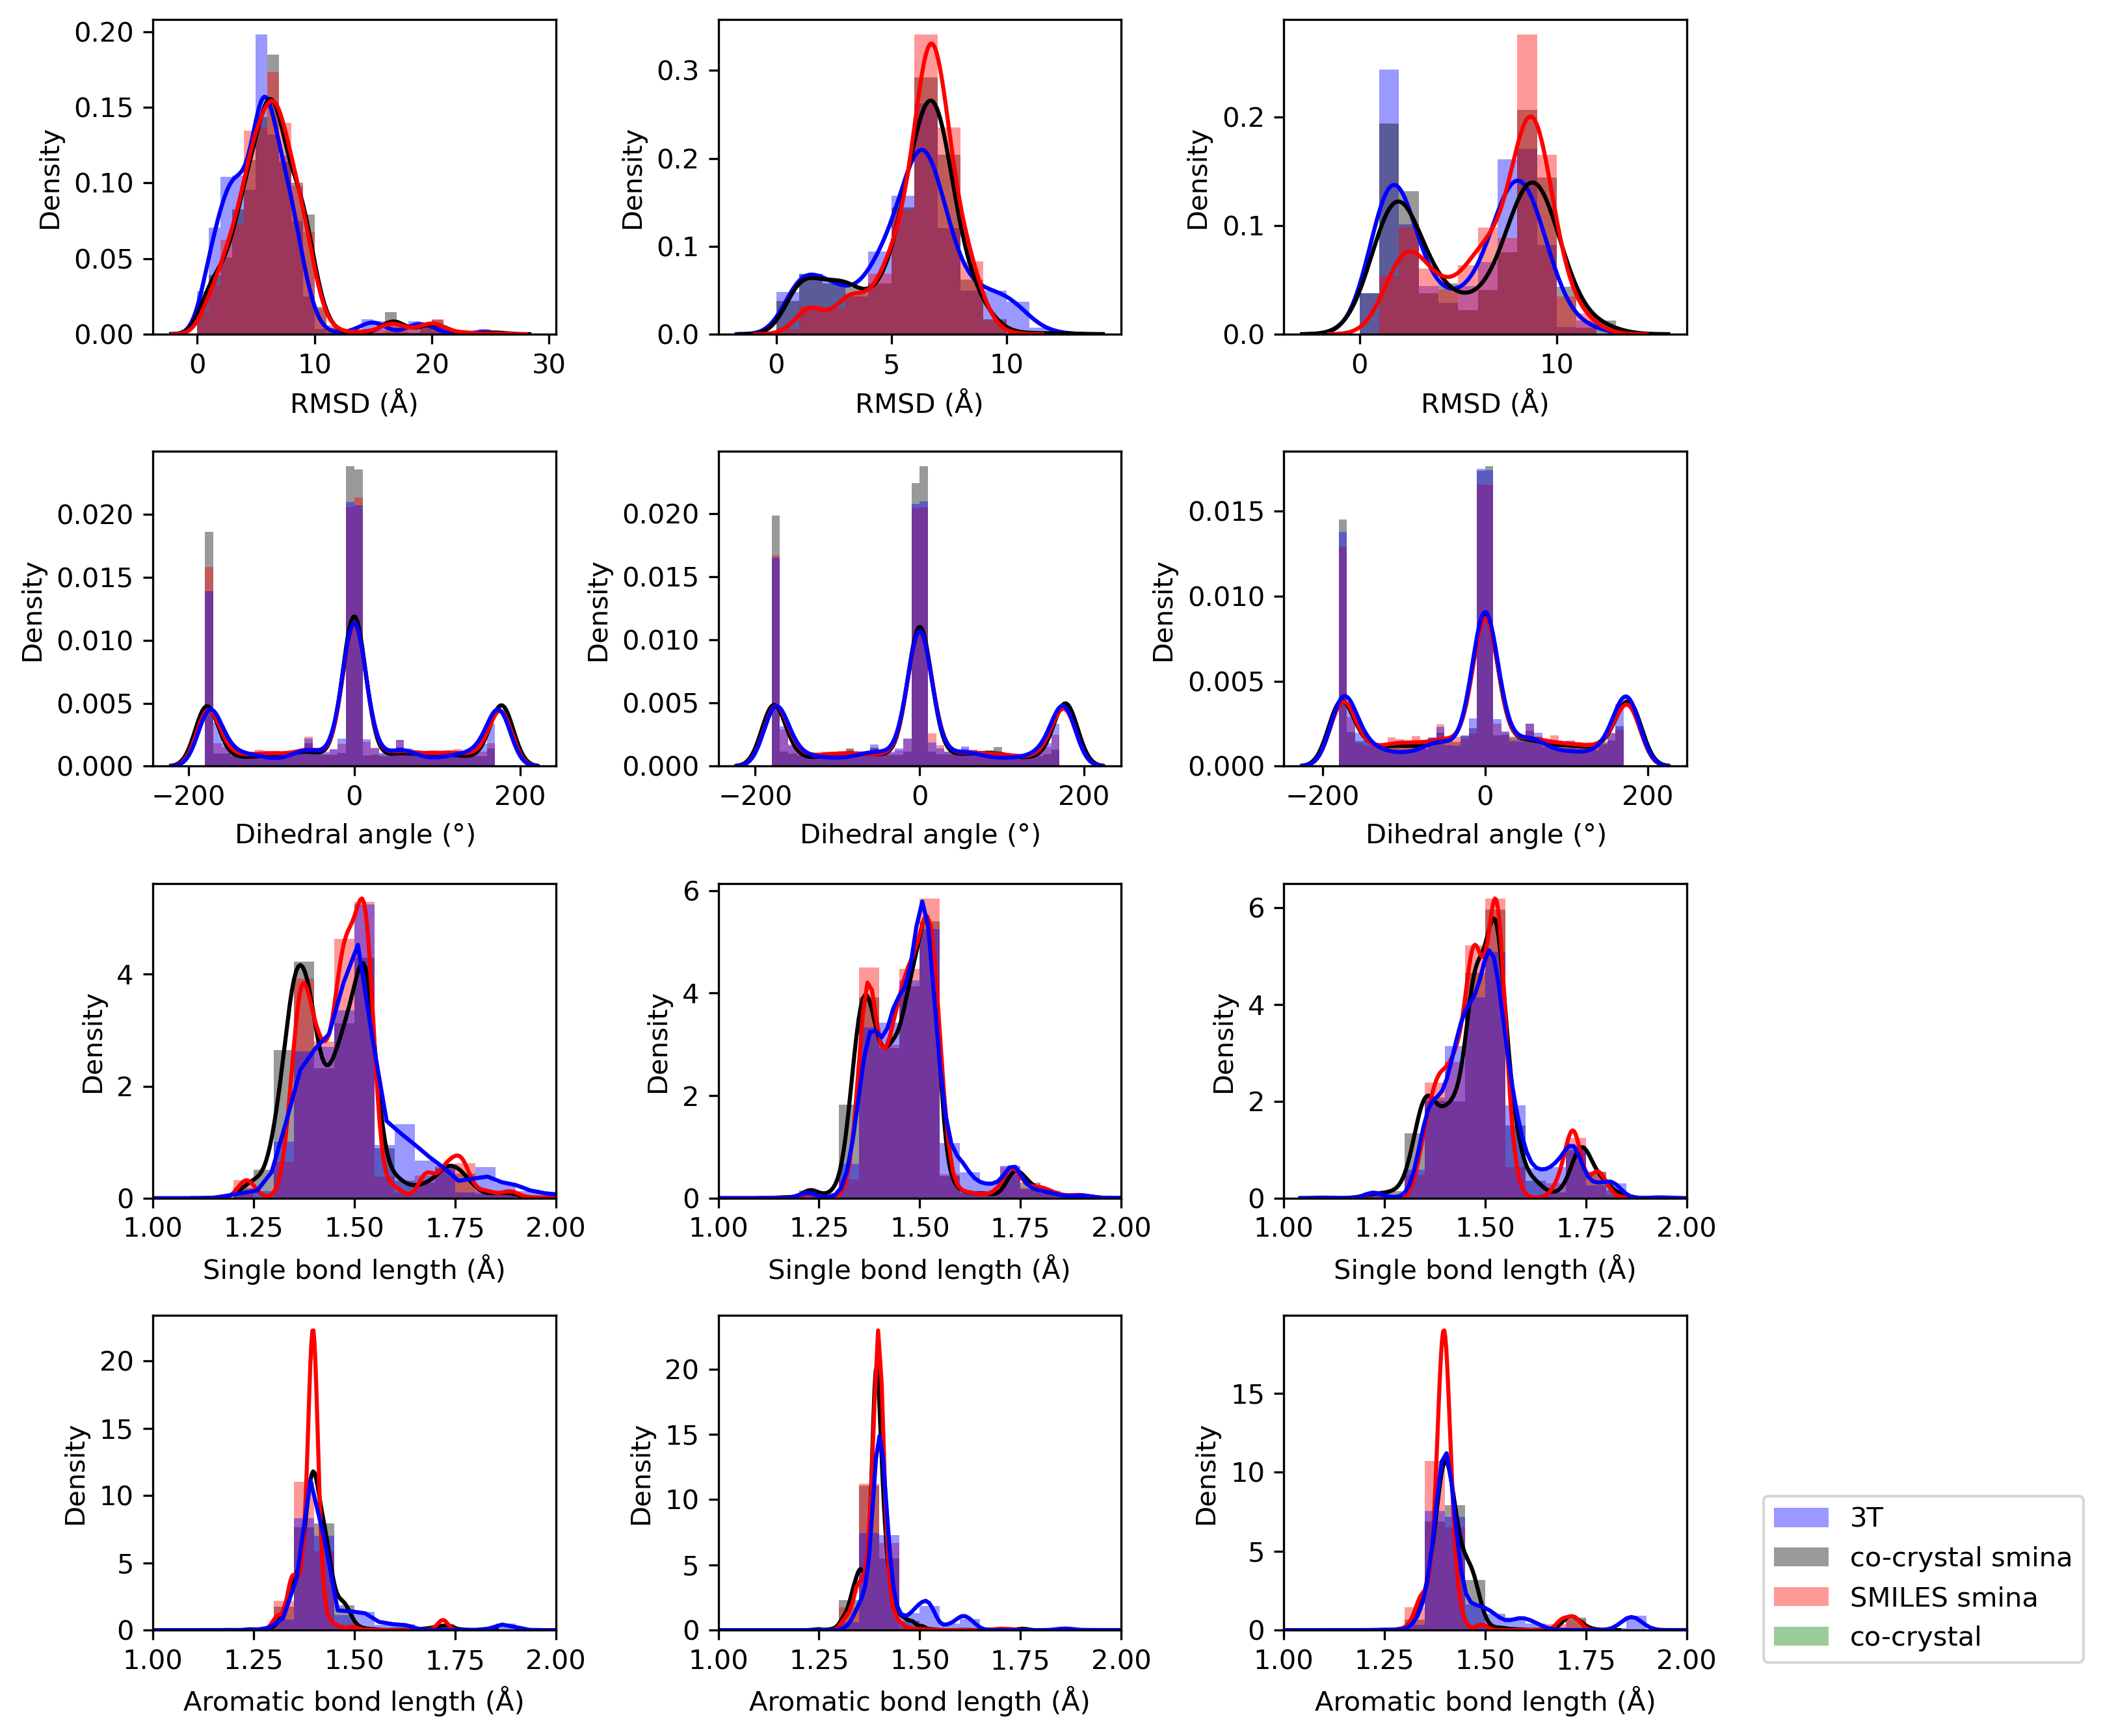

In [35]:
## draw the figure
fig, axes = plt.subplots(4,3, figsize = (9,9), dpi = 300)

# RMSD
sns.distplot(out_3t['CDK2'], ax = axes[0,0], color = 'blue', label = '3T', bins = np.arange(30))
sns.distplot(out['CDK2'], ax = axes[0,0], color = 'black', label = 'co-crystal smina', bins = np.arange(30))
sns.distplot(out_2['CDK2'], ax = axes[0,0], color = 'red', label = 'SMILES smina', bins = np.arange(30))

sns.distplot(out_3t['HSP90'], ax = axes[0,1], color = 'blue', bins = np.arange(15))
sns.distplot(out['HSP90'], ax = axes[0,1], color = 'black', bins = np.arange(15))
sns.distplot(out_2['HSP90'], ax = axes[0,1], color = 'red', bins = np.arange(15))

sns.distplot(out_3t['FXA'], ax = axes[0,2], color = 'blue', bins = np.arange(15))
sns.distplot(out['FXA'], ax = axes[0,2], color = 'black', bins = np.arange(15))
sns.distplot(out_2['FXA'], ax = axes[0,2], color = 'red', bins = np.arange(15))

## dihedral
sns.distplot(out_di_0['CDK2'], ax = axes[1,0], color = 'green', bins = np.arange(-18, 18)*10)
sns.distplot(out_di['CDK2'], ax = axes[1,0], color = 'black', bins = np.arange(-18, 18)*10)
sns.distplot(out_di_2['CDK2'], ax = axes[1,0], color = 'red', bins = np.arange(-18, 18)*10)
sns.distplot(out_di_3t['CDK2'], ax = axes[1,0], color = 'blue', bins = np.arange(-18, 18)*10)

sns.distplot(out_di_0['HSP90'], ax = axes[1,1], color = 'green', bins = np.arange(-18, 18)*10)
sns.distplot(out_di['HSP90'], ax = axes[1,1], color = 'black', bins = np.arange(-18, 18)*10)
sns.distplot(out_di_2['HSP90'], ax = axes[1,1], color = 'red', bins = np.arange(-18, 18)*10)
sns.distplot(out_di_3t['HSP90'], ax = axes[1,1], color = 'blue', bins = np.arange(-18, 18)*10)

sns.distplot(out_di_0['FXA'], ax = axes[1,2], color = 'green', label = 'co-crystal', bins = np.arange(-18, 18)*10)
sns.distplot(out_di['FXA'], ax = axes[1,2], color = 'black', bins = np.arange(-18, 18)*10)
sns.distplot(out_di_2['FXA'], ax = axes[1,2], color = 'red', bins = np.arange(-18, 18)*10)
sns.distplot(out_di_3t['FXA'], ax = axes[1,2], color = 'blue', bins = np.arange(-18, 18)*10)

# single bond
sns.distplot(out_bl_single['CDK2'], ax = axes[2,0], color = 'black', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_single_2['CDK2'], ax = axes[2,0], color = 'red', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_single_3t['CDK2'], ax = axes[2,0], color = 'blue', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_single_0['CDK2'],ax = axes[2,0], color = 'green', bins = np.arange(20,50)*0.05)

sns.distplot(out_bl_single['HSP90'], ax = axes[2,1], color = 'black', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_single_2['HSP90'], ax = axes[2,1], color = 'red', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_single_3t['HSP90'], ax = axes[2,1], color = 'blue', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_single_0['HSP90'],ax = axes[2,1], color = 'green', bins = np.arange(20,50)*0.05)

sns.distplot(out_bl_single['FXA'],ax = axes[2,2], color = 'black', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_single_2['FXA'], ax = axes[2,2], color = 'red', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_single_3t['FXA'], ax = axes[2,2], color = 'blue', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_single_0['FXA'],ax = axes[2,2], color = 'green', bins = np.arange(20,50)*0.05)


# aromatic bond
sns.distplot(out_bl_aro['CDK2'],ax = axes[3,0], color = 'black', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_aro_2['CDK2'],ax = axes[3,0], color = 'red', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_aro_3t['CDK2'],ax = axes[3,0], color = 'blue', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_aro_0['CDK2'],ax = axes[3,0], color = 'green', bins = np.arange(20,50)*0.05)

sns.distplot(out_bl_aro_0['HSP90'],ax = axes[3,1], color = 'green', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_aro['HSP90'],ax = axes[3,1], color = 'black', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_aro_2['HSP90'],ax = axes[3,1], color = 'red', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_aro_3t['HSP90'],ax = axes[3,1], color = 'blue', bins = np.arange(20,50)*0.05)

sns.distplot(out_bl_aro_0['FXA'],ax = axes[3,2], color = 'green', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_aro['FXA'],ax = axes[3,2], color = 'black', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_aro_2['FXA'],ax = axes[3,2], color = 'red', bins = np.arange(20,50)*0.05)
sns.distplot(out_bl_aro_3t['FXA'],ax = axes[3,2], color = 'blue', bins = np.arange(20,50)*0.05)


for i in [2,3]:
    for j in [0,1,2]:
        axes[i,j].set_xlim(1, 2)
for i in [0,1,2]:
    axes[0,i].set_xlabel('RMSD (Å)')
    axes[1,i].set_xlabel(r'Dihedral angle ($\degree$)')
    axes[2,i].set_xlabel('Single bond length (Å)')
    axes[3,i].set_xlabel('Aromatic bond length (Å)')
fig.legend(bbox_to_anchor =(1.2, 0.15))

plt.tight_layout()
plt.savefig('RMSD_geo_comparison.png', dpi = 300, bbox_inches = 'tight')